In [7]:
import logging
LOGGER = logging.getLogger(__name__)
LOGGER.setLevel(logging.INFO)
logging.getLogger('polymerist.rdutils.reactions').setLevel(logging.INFO)

from rdkit.Chem.rdchem import Mol
from rdkit.Chem.Draw import MolsToGridImage

## Define complete monomer inputs

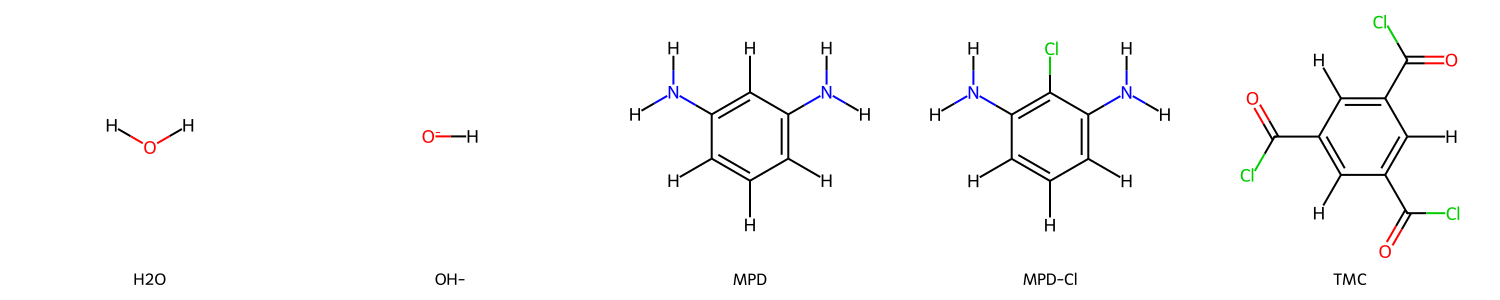

In [ ]:
from polymerist.rdutils.reactions import AnnotatedReaction, PolymerizationReactor
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES

monomer_smiles : dict[str, str] = {
    'H2O'    : '[OH2]',                               # water
    'OH-'    : '[OH-]',                               # hydroxide
    'MPD'    : 'c1ccc(N)cc1N',                        # m-phenylene diamine
    'MPD-Cl' : 'c1ccc(N)c(Cl)c1N',                    # 5-Cl m-phenylene diamine
    'TMC'    : 'c1c(C(=O)Cl)cc(C(=O)Cl)cc1(C(=O)Cl)', # trimesoyl chloride
}
monomers : dict[str, Mol] = {
    molname : explicit_mol_from_SMILES(smi)
        for molname, smi in monomer_smiles.items()
}

MolsToGridImage(
    monomers.values(),
    legends=monomers.keys(),
    molsPerRow=len(monomers),
    subImgSize=(300,300),
)

## Define reaction mechanisms

amine-acyl chloride nucleophilic addition


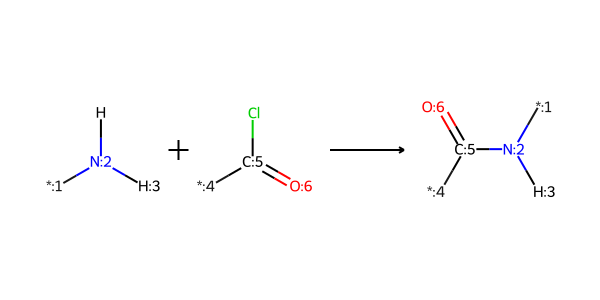

acyl chloride-hydroxyl nucleophilic substitution


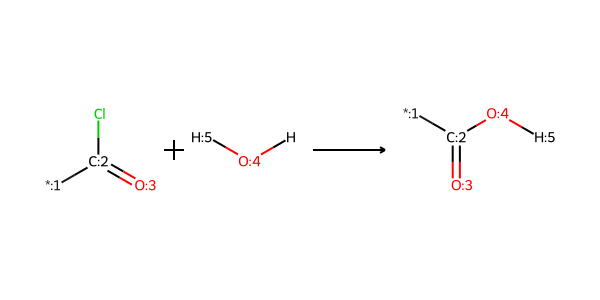

acyl chloride-hydroxide nucleophilic substitution


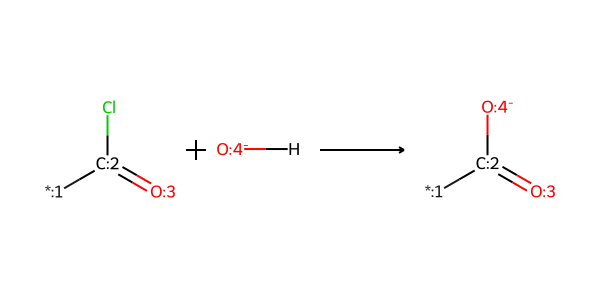

In [ ]:
rxn_smarts : dict[str, str] = { # N.B.: order here determines order reaction will be performed in
    'amine-acyl chloride nucleophilic addition' : '[*:1]-[N:2](-[#1:3])-[#1].[*:4]-[C:5](=[O:6])-Cl>>[*:1]-[N:2](-[#1:3])-[C:5](-[*:4])=[O:6]',
    'acyl chloride-hydroxyl nucleophilic substitution' : '[*:1]-[#6:2](=[#8:3])-[#17].[H]-[#8:4]-[H:5]>>[*:1]-[#6:2](=[#8:3])-[#8:4]-[H:5]',  # this one is protonated...
    'acyl chloride-hydroxide nucleophilic substitution' : '[*:1]-[#6:2](=[#8:3])-[#17].[H]-[#8-:4]>>[*:1]-[#6:2](=[#8:3])-[#8-:4]', # ...while this one is deprotonated
}

rxns : dict[str, AnnotatedReaction] = dict()
for rxnname, smarts in rxn_smarts.items():
    rxn = AnnotatedReaction.from_smarts(smarts)
    rxn.rxnname = rxnname
    rxns[rxnname] = rxn
    print(rxnname)
    display(rxn)

## Sequentially reactant-and-fragment to grow pool of molecular fragments

In [ ]:
fragments : dict[str, Mol] = monomers # begin with monomers
LOGGER.info(f'Beginning fragmentation with {len(fragments)} monomers')

for rxn in rxns.values():
    reactor = PolymerizationReactor(rxn)
    new_fragments = reactor.propagate_pooled(
        fragments.values(),
        rxn_depth_max=5,
        allow_resampling=True,
    )
    LOGGER.info(f'Discovered {len(new_fragments) - len(fragments)} new fragments after propagating reaction "{rxn.rxnname}"; adding to pool')
    fragments = new_fragments
    

INFO:__main__:Beginning fragmentation with 5 monomers
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 3 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 3 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 1 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 4 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 4 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments dis

## Compile and show final pool of fragments

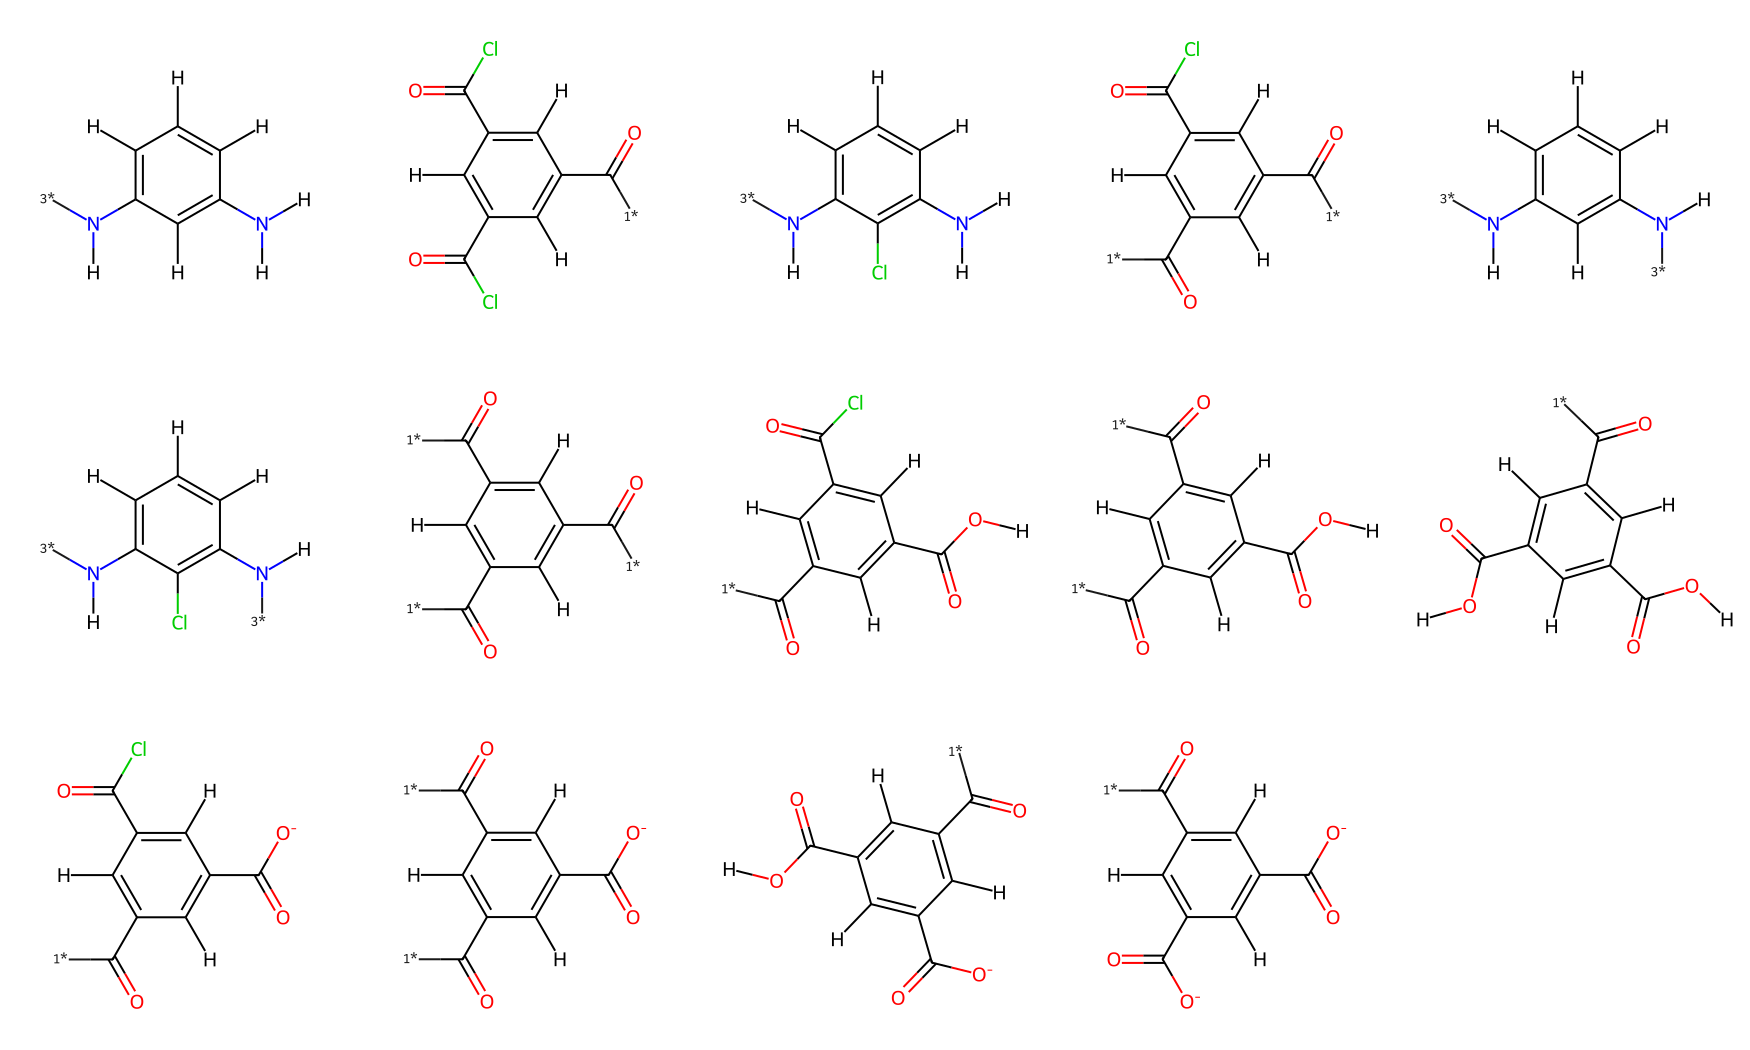

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.bonding.portlib import get_num_ports

keep_monomers : bool = False

fragments_sanitized : dict[str, Mol] = {}
for canon_smiles, mol in fragments.items():
    if (not keep_monomers) and (get_num_ports(mol) == 0):
        LOGGER.info(f'Omitting complete monomer fragment: {canon_smiles}')
        continue
    fragments_sanitized[canon_smiles] = mol
LOGGER.info(f'Final fragment pool contains {len(fragments_sanitized)} sanitized fragments')

MolsToGridImage(fragments_sanitized.values(), molsPerRow=5, subImgSize=(350,350))

### Export fragments to Structured Data File with canonical SMILES bound to each molecule

In [ ]:
from rdkit.Chem.rdmolfiles import SDWriter

with SDWriter('mpd_tmc_fragments_interactive.sdf') as writer:
    for canon_smiles, fragmol in fragments_sanitized.items():
        fragmol.SetProp('canonical SMILES', canon_smiles)
        writer.write(fragmol)